In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/Shareddrives/CS229Buddies/project')

In [3]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import collections
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve, f1_score, plot_precision_recall_curve
from scipy.stats import pearsonr
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import operator
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.linear_model import LinearRegression

In [4]:
!pip install tensorflow

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [6]:
df = pd.read_csv('data/GSE113957_fpkm.txt', sep = '\t')
df = df.T
transcript_ids = list(df.loc['Transcript ID'])

df = df.drop(['Transcript ID', 'chr', 'start', 'end', 'strand', 'Length', 'Copies', 'Annotation/Divergence'], axis=0)
df['pids'] = [column.lower().split('_')[0] for column in df.index]
hgps = set(['139', '141', '197', '198', '199', '200', '201', '202', '203', '204'])
control_df = df[~df.pids.isin(hgps)]
hgps_df = df[df.pids.isin(hgps)]
control_df = control_df.drop(['pids'], axis = 1)
hgps_df = hgps_df.drop(['pids'], axis = 1)

control_df.columns = transcript_ids
hgps_df.columns = transcript_ids

total_df = control_df.append(hgps_df)
annot=pd.read_csv("data/uniprot.tab", sep='\t')
annot=pd.read_csv("data/uniprot.tab", sep='\t')
name_d=pd.Series(annot["Gene names"].values,index=annot["yourlist:M202105245C475328CEF75220C360D524E9D456CE20BD46G"]).to_dict()
n=dict()
for k,v in name_d.items():
  if str(v)!="nan" and str(k)!="nan":
    n[k]=v.split(" ")[0]
control_df=control_df[[x for x in control_df.columns if x  in n.keys()]]
control_df.columns=[n[x] for x in control_df.columns if x  in n.keys()]

In [7]:
control_df = control_df.sum(axis=1, level=0)

In [8]:
control_df

,MPV17L,AFF4,ZGLP1,CHDH,C12orf74,ZFP90,KDM6B,DCLRE1A,LRRC3C,P2RY14,SC5DL,DSN1,KCP,SKP1,ADAMTS9,PRPF3,PARP14,HOXB1,CDV3,NELFA,P2RX3,UBR5,COASY,AP1S3,AP2M1,SPDYE3,FAM160B1,TMEM88B,RAP2B,GSDMC,FAIM,ABCC6,PCOTH,CRABP2,CARD16,SULT1C3,LTV1,AID,SGIP1,ABCC3,...,DCPS,TCTN2,DCD,SPDYE2B,SLC35G6,NPFF,HEY2,JPT1,CHID1,FLJ13052,UMODL1,RABEPK,DNAJB2,STAMBPL1,DPY19L1,EIF3M,COX6B2,FOXF2,ZNF320,EIF5A,GCGR,ACTRT3,PCSK6,PDZD7,HEL-S-41,CYBC1,MYO10,ADGRA3,SLA,MED20,GAS2L2,BPHL,PCNX4,TCEAL2,PNPLA5,RUFY3,FGFRL1,GALNT8,CCNG2,SLC25A48
101_19yr_Female_Caucasian,0.133,16.980,0.387,0.115,0.0,5.500,1.308,2.143,0.000,0.000,5.127,14.031,0.018,68.975,0.620,19.216,2.564,0.0,52.032,4.525,0.000,12.938,14.259,0.541,277.734,0.000,5.743,0.0,3.595,0.000,9.665,0.000,0.797,148.414,0.733,0.0,14.825,0.000,1.138,5.757,...,9.085,5.460,0.0,0.0,0.000,0.517,0.016,63.004,16.377,11.960,0.017,14.666,16.771,4.727,10.064,44.714,0.077,3.535,2.652,225.407,0.0,1.994,0.030,0.290,1.875,11.888,17.190,2.770,0.0,9.433,0.014,3.978,17.081,0.000,0.000,4.349,29.242,0.040,6.139,0.0
102_19yr_Male_Caucasian,0.213,16.772,0.168,0.077,0.0,6.473,1.357,1.952,0.000,0.000,3.701,13.255,0.000,61.827,0.211,11.628,1.296,0.0,36.853,3.693,0.000,11.535,11.706,0.202,284.640,0.000,5.608,0.0,2.291,0.070,6.522,0.000,0.773,315.897,0.189,0.0,9.692,0.000,0.768,7.458,...,4.988,5.093,0.0,0.0,0.000,0.289,0.000,51.358,23.395,15.450,0.000,10.447,13.185,5.360,9.991,29.864,0.029,2.435,2.613,205.338,0.0,2.873,0.022,0.441,2.624,12.583,18.545,4.020,0.0,6.454,0.000,3.378,14.215,0.000,0.000,5.642,31.561,0.000,5.603,0.0
103_19yr_Male_Caucasian,0.054,16.206,0.410,0.284,0.0,6.770,1.495,1.881,0.046,0.000,3.356,9.516,0.009,67.533,0.326,12.417,1.840,0.0,42.325,4.726,0.000,10.953,14.440,0.182,301.299,0.000,6.187,0.0,2.293,0.000,8.685,0.000,1.418,266.717,1.021,0.0,11.141,0.000,0.906,7.217,...,6.331,5.080,0.0,0.0,0.000,1.134,0.000,56.853,21.832,16.853,0.000,13.672,15.413,4.526,10.105,34.743,0.195,3.389,2.404,219.336,0.0,2.488,0.038,0.712,2.508,14.085,15.557,3.193,0.0,8.573,0.000,5.841,15.057,0.037,0.000,6.132,43.446,0.000,6.030,0.0
104_19yr_Male_Caucasian,0.066,15.345,0.148,0.304,0.0,5.773,1.688,1.927,0.056,0.039,2.455,9.884,0.000,62.057,0.503,12.878,1.867,0.0,31.844,5.389,0.000,11.372,13.423,0.183,315.602,0.000,5.836,0.0,2.931,0.018,8.092,0.000,0.612,125.909,0.974,0.0,9.815,0.000,0.800,4.697,...,6.785,2.450,0.0,0.0,0.000,1.488,0.000,50.358,22.499,13.521,0.010,13.590,16.273,5.067,8.320,31.115,0.059,3.466,1.996,183.929,0.0,3.150,0.034,0.573,2.339,14.824,15.571,3.297,0.0,8.485,0.000,2.237,14.247,0.000,0.022,3.752,39.371,0.000,5.048,0.0
105_20yr_Male_Caucasian,0.156,16.873,0.252,0.094,0.0,5.052,1.384,2.815,0.000,0.000,5.745,13.131,0.011,63.981,0.242,14.719,1.448,0.0,43.607,4.981,0.000,11.345,14.707,0.398,283.420,0.016,6.723,0.0,1.785,0.018,6.667,0.000,0.934,66.549,0.264,0.0,13.647,0.018,0.682,5.021,...,7.448,4.852,0.0,0.0,0.000,1.152,0.000,70.406,17.125,12.348,0.000,11.550,12.744,4.777,9.909,39.632,0.000,1.822,2.437,239.498,0.0,1.517,0.081,0.097,0.794,11.617,15.222,4.057,0.0,8.247,0.000,3.537,14.088,0.091,0.000,4.833,18.592,0.000,3.794,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94_12_male_Caucasian,0.214,16.103,0.323,0.086,0.0,4.877,1.369,2.212,0.000,0.000,2.828,15.166,0.011,68.210,0.340,12.354,1.515,0.0,38.405,4.744,0.000,11.523,10.250,0.213,296.900,0.000,6.835,0.0,2.289,0.020,9.337,0.000,0.866,91.985,0.354,0.0,13.846,0.000,0.525,4.576,...,4.795,4.050,0.0,0.0,0.000,1.167,0.000,58.212,24.508,12.198,0.011,11.990,14.284,5.188,6.789,37.820,0.032,2.996,1.594,220.301,0.0,2.155,0.012,0.208,2.613,14.377,10.419,2.737,0.0,7.695,0.000,2.666,14.963,0.049,0.000,4.494,28.903,0.000,6.531,0.0
95_13yr_Male_WhiTEEASTINDIAN,0.041,15.899,0.486,0.087,0.0,5.026,1.080,2.565,0.0

In [ ]:
def filter_genes(X_train, X_test):
  genes=[]
  for col in X_train.columns:
    vec=np.array(X_train[col])
    if vec.max()> 5 and vec.max()-vec.min()>5*vec.min():
      genes.append(col)
  return X_train[genes], X_test[genes]

In [ ]:
loo=LeaveOneOut()
X=control_df
X=X.reset_index()
X=X.drop(["index"], axis=1)
labels = list(control_df.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y=np.array(control_ages)
n_genes=[]
y_pred=[]
y_act=[]
i=0
for train_index, test_index in loo.split(X):
  print(i)
  i+=1
  X_train, X_test = filter_genes(X.loc[train_index], X.loc[test_index])
  y_train, y_test = y[train_index], y[test_index]
  X_train = np.asarray(X_train).astype('float32')
  X_test = np.asarray(X_test).astype('float32')
  n_genes.append(X_train.shape[1])
  tf.keras.backend.clear_session()
  tf.random.set_seed(60)
  model=keras.models.Sequential([
  
  keras.layers.Dense(500, input_dim = X_train.shape[1], activation='relu'),  
  # keras.layers.Dense(256, input_dim = X_train.shape[1], activation='relu'),  
  # keras.layers.Dense(units=128,activation='relu'),  
  # keras.layers.Dense(units=256,activation='relu'),    
  # keras.layers.Dense(units=128,activation='relu'),
  keras.layers.Dense(units=1, activation="linear"),
  ],name="Initial_model",)
  # model.summary()
  optimizer = keras.optimizers.Adam()
  model.compile(optimizer=optimizer, 
              loss='mean_absolute_error')
  history = model.fit(X_train, y_train,
                      epochs=100, batch_size=10,
                      validation_data=(X_test, y_test), 
                      verbose=1)
  y_pred.append(model.predict(X_test))
  y_act.append(y_test)
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])

Streaming output truncated to the last 5000 lines.
Epoch 13/100
14/14 [==============================] - 0s 13ms/step - loss: 20.8732 - val_loss: 14.0344
Epoch 14/100
14/14 [==============================] - 0s 17ms/step - loss: 20.1956 - val_loss: 1.9243
Epoch 15/100
14/14 [==============================] - 0s 15ms/step - loss: 18.1530 - val_loss: 13.9894
Epoch 16/100
14/14 [==============================] - 0s 13ms/step - loss: 18.5604 - val_loss: 21.8722
Epoch 17/100
14/14 [==============================] - 0s 14ms/step - loss: 23.1533 - val_loss: 8.9782
Epoch 18/100
14/14 [==============================] - 0s 14ms/step - loss: 22.8942 - val_loss: 11.3750
Epoch 19/100
14/14 [==============================] - 0s 14ms/step - loss: 33.2319 - val_loss: 19.5773
Epoch 20/100
14/14 [==============================] - 0s 17ms/step - loss: 18.6289 - val_loss: 8.3879
Epoch 21/100
14/14 [==============================] - 0s 14ms/step - loss: 32.3983 - val_loss: 5.4834
Epoch 22/100
14/14 [======

In [ ]:
from scipy.stats import pearsonr

In [ ]:
y_pred.flatten()

array([ 37.762497 ,  49.49035  ,  36.900196 ,  21.87989  ,  26.453264 ,
        51.9338   ,  37.881588 ,  29.785036 ,  26.988014 ,  39.1709   ,
        39.963238 ,  32.78244  ,  49.008736 ,  42.81594  ,  71.19686  ,
        54.142933 ,  55.699562 ,  42.23682  ,  45.128956 ,  59.64887  ,
        50.065506 ,  38.90868  ,  47.66372  ,  41.955765 ,  42.792393 ,
        91.16259  ,  83.51354  ,  79.6961   ,  66.78666  , 113.47035  ,
       100.1032   ,  89.77925  ,  79.47584  ,   6.108729 ,  16.131506 ,
        19.123274 ,  33.568886 ,   9.477454 ,  37.45491  ,  49.39506  ,
        52.826572 ,  50.920517 ,  44.65885  ,  86.6325   ,  53.043896 ,
        61.44144  ,  51.35687  ,  55.056713 ,  47.44299  ,  93.18784  ,
        39.277416 ,  73.55044  ,  63.999496 ,  62.99626  ,  30.084087 ,
        27.50121  ,  32.9188   ,  26.957792 ,  33.9995   ,  45.444637 ,
        44.035385 ,  22.61202  ,  62.284237 ,  60.766533 ,  35.200947 ,
        47.487556 ,  64.33571  ,  65.37751  ,  69.0336   ,  44.0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


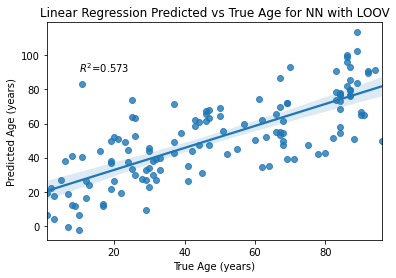

In [ ]:
sns.regplot(y_act,y_pred)
r, p = pearsonr(np.array(y_act),y_pred.flatten())
plt.xlabel('True Age (years)')
plt.ylabel('Predicted Age (years)')
plt.title("Linear Regression Predicted vs True Age for NN with LOOV")
plt.text(10,90,s="$R^2$=" + str(round(r**2, 3)))
plt.savefig('results/NN_pred_true_age_linreg.png')


In [ ]:
pearsonr(y_act,y_pred)

In [ ]:
for train_index, test_index in loo.split(X):
  if test_index[0]>46:
    X_train, X_test = filter_genes(X.loc[train_index], X.loc[test_index])
    y_train, y_test = y[train_index], y[test_index]
    X_train = np.asarray(X_train).astype('float32')
    X_test = np.asarray(X_test).astype('float32')
    n_genes.append(X_train.shape[1])
    tf.keras.backend.clear_session()
    tf.random.set_seed(60)
    model=keras.models.Sequential([
    
    keras.layers.Dense(512, input_dim = X_train.shape[1], activation='relu'),  
    # keras.layers.Dense(256, input_dim = X_train.shape[1], activation='relu'),  
    # keras.layers.Dense(units=128,activation='relu'),  
    # keras.layers.Dense(units=256,activation='relu'),    
    # keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=1, activation="linear"),
    ],name="Initial_model",)
    model.summary()
    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer, 
                loss='mean_absolute_error')
    history = model.fit(X_train, y_train,
                        epochs=200, batch_size=10,
                        validation_data=(X_test, y_test), 
                        verbose=1)
    y_pred.append(model.predict(X_test)[0])
    y_act.append(y_test[0])
    print(model.predict(X_test)[0])
# y_pred = np.array([y[0] for y in y_pred])
# y_act = np.array([y[0] for y in y_act])

Model: "Initial_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1652224   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,652,737
Trainable params: 1,652,737
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
14/14 [==============================] - 1s 17ms/step - loss: 397.7771 - val_loss: 231.8176
Epoch 2/200
14/14 [==============================] - 0s 10ms/step - loss: 169.3007 - val_loss: 179.9895
Epoch 3/200
14/14 [==============================] - 0s 10ms/step - loss: 115.1985 - val_loss: 43.6042
Epoch 4/200
14/14 [==============================] - 0s 10ms/step - loss: 80.7763 - val_loss: 165.8640
Epoch 5/200
14/14 [==============================] - 0s 10ms/step - loss: 80.8499 - val_los

KeyboardInterrupt: ignored

In [ ]:
for train_index, test_index in loo.split(X):
  print(train_index,test_index)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132] [0]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 

In [ ]:
y_pred = np.array([y[0] for y in y_pred])
y_act = np.array([y[0] for y in y_act])

In [ ]:
import scipy.stats as stats

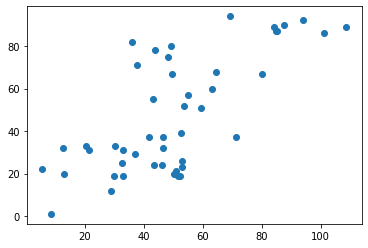

In [ ]:
plt.scatter(y_pred,y_act)

In [ ]:
X_train=control_df.sample(frac=.8, random_state=12)
labels = list(X_train.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
y_train=np.array(control_ages)
y_train = np.asarray(y_train).astype('float32')
X_test=control_df.drop(X_train.index)
labels = list(X_test.index)
control_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test=np.array(control_ages)
y_test = np.asarray(y_test).astype('float32')

In [ ]:
# tf.keras.backend.clear_session()
# tf.random.set_seed(60)
# model=keras.models.Sequential([
    
#     keras.layers.Dense(512, input_dim = X_train.shape[1], activation='relu'),  
#     keras.layers.Dense(256, input_dim = X_train.shape[1], activation='relu'),  
#     keras.layers.Dense(units=128,activation='relu'),  
#     # keras.layers.Dense(units=256,activation='relu'),    
#     # keras.layers.Dense(units=128,activation='relu'),
#     keras.layers.Dense(units=1, activation="linear"),
# ],name="Initial_model",)
# model.summary()

Model: "Initial_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               8504320   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 8,668,673
Trainable params: 8,668,673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(60)
model=keras.models.Sequential([
    
    keras.layers.Dense(500, input_dim = X_train.shape[1], activation='relu'),  
    # keras.layers.Dense(256, input_dim = X_train.shape[1], activation='relu'),  
    # keras.layers.Dense(units=128,activation='relu'),  
    # keras.layers.Dense(units=256,activation='relu'),    
    # keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=1, activation="linear"),
],name="Initial_model",)
model.summary()

Model: "Initial_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               8305000   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 8,305,501
Trainable params: 8,305,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, 
            loss='mean_absolute_error')
history = model.fit(X_train, y_train,
                    epochs=100, batch_size=10,
                    validation_data=(X_test, y_test), 
                    verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 57ms/step - loss: 893.9932 - val_loss: 204.1968
Epoch 2/100
11/11 [==============================] - 0s 46ms/step - loss: 196.1722 - val_loss: 86.4881
Epoch 3/100
11/11 [==============================] - 1s 46ms/step - loss: 61.5507 - val_loss: 17.9418
Epoch 4/100
11/11 [==============================] - 0s 45ms/step - loss: 30.9256 - val_loss: 36.8531
Epoch 5/100
11/11 [==============================] - 0s 45ms/step - loss: 22.0457 - val_loss: 14.2003
Epoch 6/100
11/11 [==============================] - 0s 46ms/step - loss: 17.5484 - val_loss: 31.3064
Epoch 7/100
11/11 [==============================] - 1s 46ms/step - loss: 18.2489 - val_loss: 19.1327
Epoch 8/100
11/11 [==============================] - 0s 45ms/step - loss: 15.3993 - val_loss: 12.4099
Epoch 9/100
11/11 [==============================] - 0s 45ms/step - loss: 17.3075 - val_loss: 18.2917
Epoch 10/100
11/11 [==============================] - 0s 46ms/step - loss: 24.7

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  # plt.xlim((50,200))
  plt.ylim((0,200))
  plt.legend()
  plt.grid(True)
  plt.savefig("results/nn_loss_epochs.png")

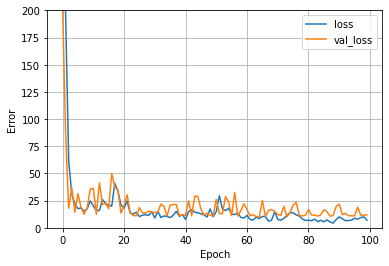

In [ ]:
plot_loss(history)

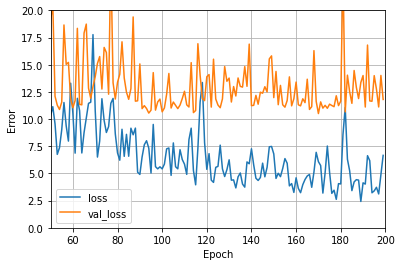

In [ ]:
plot_loss(history)

In [ ]:
y_pred=[x[0] for x in model.predict(X_test)]

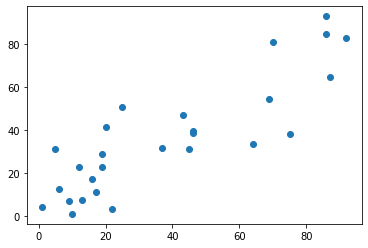

In [ ]:
plt.scatter(y_test,y_pred)

In [ ]:
for k,v in name_d.items():
  if str(v)!="nan" and str(k)!="nan":
    n[k]=v.split(" ")[0]
hgps_df=hgps_df[[x for x in hgps_df.columns if x  in n.keys()]]
hgps_df.columns=[n[x] for x in hgps_df.columns if x  in n.keys()]

In [ ]:
labels = list(hgps_df.index)
hgps_ages = [int(label.lower().split('_')[1].split('y')[0]) for label in labels]
hgps= np.asarray(hgps_df).astype('float32')

In [ ]:
y_pred=[x[0] for x in model.predict(hgps)]

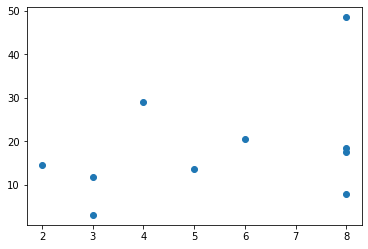

In [ ]:
plt.scatter(hgps_ages,y_pred)

In [ ]:
from keras import backend as K


In [ ]:
#The layer number
n = 0
# with a Sequential model
get_nth_layer_output = K.function([model.layers[0].input],
                                  [model.layers[n].output])
layer_output = get_nth_layer_output([[X_test[0:1,:]]])

In [ ]:
layer_output[0].shape

(1, 512)

In [ ]:
X_test[0:1,:].shape

(1, 16609)

In [ ]:
control_df

,MPV17L,AFF4,ZGLP1,CHDH,C12orf74,ZFP90,KDM6B,DCLRE1A,LRRC3C,P2RY14,SC5DL,DSN1,KCP,SKP1,ADAMTS9,PRPF3,PARP14,HOXB1,CDV3,NELFA,P2RX3,UBR5,COASY,AP1S3,AP2M1,SPDYE3,FAM160B1,TMEM88B,RAP2B,GSDMC,FAIM,ABCC6,PCOTH,CRABP2,CARD16,SULT1C3,LTV1,AID,SGIP1,ABCC3,...,DCPS,TCTN2,DCD,SPDYE2B,SLC35G6,NPFF,HEY2,JPT1,CHID1,FLJ13052,UMODL1,RABEPK,DNAJB2,STAMBPL1,DPY19L1,EIF3M,COX6B2,FOXF2,ZNF320,EIF5A,GCGR,ACTRT3,PCSK6,PDZD7,HEL-S-41,CYBC1,MYO10,ADGRA3,SLA,MED20,GAS2L2,BPHL,PCNX4,TCEAL2,PNPLA5,RUFY3,FGFRL1,GALNT8,CCNG2,SLC25A48
101_19yr_Female_Caucasian,0.133,16.98,0.387,0.115,0,5.5,1.308,2.143,0,0,5.127,14.031,0.018,68.975,0.62,19.216,2.564,0,52.032,4.525,0,12.938,14.259,0.541,277.734,0,5.743,0,3.595,0,9.665,0,0.797,148.414,0.733,0,14.825,0,1.138,5.757,...,9.085,5.46,0,0,0,0.517,0.016,63.004,16.377,11.96,0.017,14.666,16.771,4.727,10.064,44.714,0.077,3.535,2.652,225.407,0,1.994,0.03,0.29,1.875,11.888,17.19,2.77,0,9.433,0.014,3.978,17.081,0,0,4.349,29.242,0.04,6.139,0
102_19yr_Male_Caucasian,0.213,16.772,0.168,0.077,0,6.473,1.357,1.952,0,0,3.701,13.255,0,61.827,0.211,11.628,1.296,0,36.853,3.693,0,11.535,11.706,0.202,284.64,0,5.608,0,2.291,0.07,6.522,0,0.773,315.897,0.189,0,9.692,0,0.768,7.458,...,4.988,5.093,0,0,0,0.289,0,51.358,23.395,15.45,0,10.447,13.185,5.36,9.991,29.864,0.029,2.435,2.613,205.338,0,2.873,0.022,0.441,2.624,12.583,18.545,4.02,0,6.454,0,3.378,14.215,0,0,5.642,31.561,0,5.603,0
103_19yr_Male_Caucasian,0.054,16.206,0.41,0.284,0,6.77,1.495,1.881,0.046,0,3.356,9.516,0.009,67.533,0.326,12.417,1.84,0,42.325,4.726,0,10.953,14.44,0.182,301.299,0,6.187,0,2.293,0,8.685,0,1.418,266.717,1.021,0,11.141,0,0.906,7.217,...,6.331,5.08,0,0,0,1.134,0,56.853,21.832,16.853,0,13.672,15.413,4.526,10.105,34.743,0.195,3.389,2.404,219.336,0,2.488,0.038,0.712,2.508,14.085,15.557,3.193,0,8.573,0,5.841,15.057,0.037,0,6.132,43.446,0,6.03,0
104_19yr_Male_Caucasian,0.066,15.345,0.148,0.304,0,5.773,1.688,1.927,0.056,0.039,2.455,9.884,0,62.057,0.503,12.878,1.867,0,31.844,5.389,0,11.372,13.423,0.183,315.602,0,5.836,0,2.931,0.018,8.092,0,0.612,125.909,0.974,0,9.815,0,0.8,4.697,...,6.785,2.45,0,0,0,1.488,0,50.358,22.499,13.521,0.01,13.59,16.273,5.067,8.32,31.115,0.059,3.466,1.996,183.929,0,3.15,0.034,0.573,2.339,14.824,15.571,3.297,0,8.485,0,2.237,14.247,0,0.022,3.752,39.371,0,5.048,0
105_20yr_Male_Caucasian,0.156,16.873,0.252,0.094,0,5.052,1.384,2.815,0,0,5.745,13.131,0.011,63.981,0.242,14.719,1.448,0,43.607,4.981,0,11.345,14.707,0.398,283.42,0.016,6.723,0,1.785,0.018,6.667,0,0.934,66.549,0.264,0,13.647,0.018,0.682,5.021,...,7.448,4.852,0,0,0,1.152,0,70.406,17.125,12.348,0,11.55,12.744,4.777,9.909,39.632,0,1.822,2.437,239.498,0,1.517,0.081,0.097,0.794,11.617,15.222,4.057,0,8.247,0,3.537,14.088,0.091,0,4.833,18.592,0,3.794,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94_12_male_Caucasian,0.214,16.103,0.323,0.086,0,4.877,1.369,2.212,0,0,2.828,15.166,0.011,68.21,0.34,12.354,1.515,0,38.405,4.744,0,11.523,10.25,0.213,296.9,0,6.835,0,2.289,0.02,9.337,0,0.866,91.985,0.354,0,13.846,0,0.525,4.576,...,4.795,4.05,0,0,0,1.167,0,58.212,24.508,12.198,0.011,11.99,14.284,5.188,6.789,37.82,0.032,2.996,1.594,220.301,0,2.155,0.012,0.208,2.613,14.377,10.419,2.737,0,7.695,0,2.666,14.963,0.049,0,4.494,28.903,0,6.531,0
95_13yr_Male_WhiTEEASTINDIAN,0.041,15.899,0.486,0.087,0,5.026,1.08,2.565,0,0,3.844,14.403,0.029,79.071,0.362,18.623,1.301,0,46.275,4.595,0,11.922,16.716,0.366,321.673,0,6.501,0,2.59,0,10.509,0,1.202,100.292,0.486,0,18.221,0,0.847,3.881,...,9.444,5.486,0,0,0.038,1.114,0,86.099,21.435,12.722,0,13.94,13.687,11.566,8.038,47.919,0.055,3.222,2.187,236.225,0,2.627,0.021,0.179,2.609,12.717,19.513,3.024,0,8.792,0,4.604,15.81,0.042,0,4.22,25.312,0,5.199,0
97_16yr_Female_Unknown,0.204,16.79,0.385,0.014,0,

In [ ]:
GO=pd.read_csv("gseapy_results/GO_Biological_Process_2018.human.enrichr.reports.txt", sep="\t")
GO_map=pd.Series(GO["Genes"].values,index=GO["Term"]).to_dict()
l=list(GO_map.keys())
for k in l:
  genes=set(GO_map[k].split(";"))
  if len(genes)>10 & len(genes)<500:
    GO_map[k]=genes&set(control_df.columns)
  else:
    GO_map.pop(k)

In [ ]:
df[0]

MPV17L       0.108000
AFF4        17.884001
ZGLP1        0.400000
CHDH         0.218000
C12orf74     0.000000
              ...    
RUFY3        5.642000
FGFRL1      23.009001
GALNT8       0.000000
CCNG2        6.177000
SLC25A48     0.000000
Name: 0, Length: 16609, dtype: float32

In [ ]:
med=dict()
max=dict()
for col in control_df.columns:
  med[col]=np.median(control_df[col])
  max[col]=np.max(control_df[col])


In [ ]:
df=pd.DataFrame.from_dict(med, orient="index").astype('float32')

In [ ]:
control_df

,MPV17L,AFF4,ZGLP1,CHDH,C12orf74,ZFP90,KDM6B,DCLRE1A,LRRC3C,P2RY14,SC5DL,DSN1,KCP,SKP1,ADAMTS9,PRPF3,PARP14,HOXB1,CDV3,NELFA,P2RX3,UBR5,COASY,AP1S3,AP2M1,SPDYE3,FAM160B1,TMEM88B,RAP2B,GSDMC,FAIM,ABCC6,PCOTH,CRABP2,CARD16,SULT1C3,LTV1,AID,SGIP1,ABCC3,...,DCPS,TCTN2,DCD,SPDYE2B,SLC35G6,NPFF,HEY2,JPT1,CHID1,FLJ13052,UMODL1,RABEPK,DNAJB2,STAMBPL1,DPY19L1,EIF3M,COX6B2,FOXF2,ZNF320,EIF5A,GCGR,ACTRT3,PCSK6,PDZD7,HEL-S-41,CYBC1,MYO10,ADGRA3,SLA,MED20,GAS2L2,BPHL,PCNX4,TCEAL2,PNPLA5,RUFY3,FGFRL1,GALNT8,CCNG2,SLC25A48
101_19yr_Female_Caucasian,0.133,16.980,0.387,0.115,0.0,5.500,1.308,2.143,0.000,0.000,5.127,14.031,0.018,68.975,0.620,19.216,2.564,0.0,52.032,4.525,0.000,12.938,14.259,0.541,277.734,0.000,5.743,0.0,3.595,0.000,9.665,0.000,0.797,148.414,0.733,0.0,14.825,0.000,1.138,5.757,...,9.085,5.460,0.0,0.0,0.000,0.517,0.016,63.004,16.377,11.960,0.017,14.666,16.771,4.727,10.064,44.714,0.077,3.535,2.652,225.407,0.0,1.994,0.030,0.290,1.875,11.888,17.190,2.770,0.0,9.433,0.014,3.978,17.081,0.000,0.000,4.349,29.242,0.040,6.139,0.0
102_19yr_Male_Caucasian,0.213,16.772,0.168,0.077,0.0,6.473,1.357,1.952,0.000,0.000,3.701,13.255,0.000,61.827,0.211,11.628,1.296,0.0,36.853,3.693,0.000,11.535,11.706,0.202,284.640,0.000,5.608,0.0,2.291,0.070,6.522,0.000,0.773,315.897,0.189,0.0,9.692,0.000,0.768,7.458,...,4.988,5.093,0.0,0.0,0.000,0.289,0.000,51.358,23.395,15.450,0.000,10.447,13.185,5.360,9.991,29.864,0.029,2.435,2.613,205.338,0.0,2.873,0.022,0.441,2.624,12.583,18.545,4.020,0.0,6.454,0.000,3.378,14.215,0.000,0.000,5.642,31.561,0.000,5.603,0.0
103_19yr_Male_Caucasian,0.054,16.206,0.410,0.284,0.0,6.770,1.495,1.881,0.046,0.000,3.356,9.516,0.009,67.533,0.326,12.417,1.840,0.0,42.325,4.726,0.000,10.953,14.440,0.182,301.299,0.000,6.187,0.0,2.293,0.000,8.685,0.000,1.418,266.717,1.021,0.0,11.141,0.000,0.906,7.217,...,6.331,5.080,0.0,0.0,0.000,1.134,0.000,56.853,21.832,16.853,0.000,13.672,15.413,4.526,10.105,34.743,0.195,3.389,2.404,219.336,0.0,2.488,0.038,0.712,2.508,14.085,15.557,3.193,0.0,8.573,0.000,5.841,15.057,0.037,0.000,6.132,43.446,0.000,6.030,0.0
104_19yr_Male_Caucasian,0.066,15.345,0.148,0.304,0.0,5.773,1.688,1.927,0.056,0.039,2.455,9.884,0.000,62.057,0.503,12.878,1.867,0.0,31.844,5.389,0.000,11.372,13.423,0.183,315.602,0.000,5.836,0.0,2.931,0.018,8.092,0.000,0.612,125.909,0.974,0.0,9.815,0.000,0.800,4.697,...,6.785,2.450,0.0,0.0,0.000,1.488,0.000,50.358,22.499,13.521,0.010,13.590,16.273,5.067,8.320,31.115,0.059,3.466,1.996,183.929,0.0,3.150,0.034,0.573,2.339,14.824,15.571,3.297,0.0,8.485,0.000,2.237,14.247,0.000,0.022,3.752,39.371,0.000,5.048,0.0
105_20yr_Male_Caucasian,0.156,16.873,0.252,0.094,0.0,5.052,1.384,2.815,0.000,0.000,5.745,13.131,0.011,63.981,0.242,14.719,1.448,0.0,43.607,4.981,0.000,11.345,14.707,0.398,283.420,0.016,6.723,0.0,1.785,0.018,6.667,0.000,0.934,66.549,0.264,0.0,13.647,0.018,0.682,5.021,...,7.448,4.852,0.0,0.0,0.000,1.152,0.000,70.406,17.125,12.348,0.000,11.550,12.744,4.777,9.909,39.632,0.000,1.822,2.437,239.498,0.0,1.517,0.081,0.097,0.794,11.617,15.222,4.057,0.0,8.247,0.000,3.537,14.088,0.091,0.000,4.833,18.592,0.000,3.794,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94_12_male_Caucasian,0.214,16.103,0.323,0.086,0.0,4.877,1.369,2.212,0.000,0.000,2.828,15.166,0.011,68.210,0.340,12.354,1.515,0.0,38.405,4.744,0.000,11.523,10.250,0.213,296.900,0.000,6.835,0.0,2.289,0.020,9.337,0.000,0.866,91.985,0.354,0.0,13.846,0.000,0.525,4.576,...,4.795,4.050,0.0,0.0,0.000,1.167,0.000,58.212,24.508,12.198,0.011,11.990,14.284,5.188,6.789,37.820,0.032,2.996,1.594,220.301,0.0,2.155,0.012,0.208,2.613,14.377,10.419,2.737,0.0,7.695,0.000,2.666,14.963,0.049,0.000,4.494,28.903,0.000,6.531,0.0
95_13yr_Male_WhiTEEASTINDIAN,0.041,15.899,0.486,0.087,0.0,5.026,1.080,2.565,0.0

In [ ]:
import random

In [ ]:
def get_rando():
  patient=[]
  l=control_df.shape[0]
  for col in control_df.columns:
    patient.append(list(control_df[col])[random.randint(0,l-1)])
  return patient

In [ ]:
len(patient)

16609

In [ ]:
def fake_patient(pathway):
  dfp=df.copy()
  for gene in GO_map[pathway]:
    dfp.loc[gene,:]=max[gene]
  return np.array([dfp[0]]).astype('float32')

In [ ]:
features=pd.read_csv("GO_GSEA_features.csv")

In [ ]:
ps=[]
for i in range(1000):
  patient=get_rando()
  ps.append(patient)
ps=np.array(ps).astype('float32')

n = 3
# with a Sequential model
get_nth_layer_output = K.function([model.layers[0].input],
                                  [model.layers[n].output])
layer_output = get_nth_layer_output([ps])
  

In [ ]:
null_distribution=layer_output[0]

In [ ]:
n = 3
# with a Sequential model
get_nth_layer_output = K.function([model.layers[0].input],
                                  [model.layers[n].output])
layer_output = get_nth_layer_output([ps])
  

In [ ]:
layer_output

[array([[63.157284],
        [53.097946],
        [41.36934 ],
        [48.4048  ],
        [38.12782 ],
        [26.843664],
        [38.75007 ],
        [50.894424],
        [68.42055 ],
        [66.04005 ],
        [52.195576],
        [66.32192 ],
        [37.020824],
        [33.50438 ],
        [49.472343],
        [63.116318],
        [41.70668 ],
        [74.220825],
        [50.635986],
        [49.60055 ],
        [59.66037 ],
        [49.14329 ],
        [41.509956],
        [36.082645],
        [65.124435],
        [53.42664 ],
        [82.167946],
        [43.975693],
        [78.74415 ],
        [72.59863 ],
        [33.29143 ],
        [45.554077],
        [37.048157],
        [53.239777],
        [32.6817  ],
        [36.540398],
        [49.229683],
        [45.30426 ],
        [46.597225],
        [42.69553 ],
        [49.36348 ],
        [44.54454 ],
        [30.485918],
        [57.661785],
        [41.57785 ],
        [97.562126],
        [45.687965],
        [38.9

In [ ]:
p_map=dict()
for pathway in features.index:
  p_vals=[]
  fake_output= get_nth_layer_output(fake_patient(pathway))[0][0]
  for i in range(null_distribution.shape[1]):
    p=np.mean([int(x>=fake_output[i]) for x in list(null_distribution[:,i])])
    p_vals.append(p)
  print(np.min(p_vals))
  p_map[pathway]=p_vals
  

0.523
0.617
0.561
0.812
0.702
0.808
0.702
0.654
0.706
0.818
0.747
0.553
0.749
0.644
0.749
0.546
0.743
0.761
0.744
0.745
0.706
0.702
0.691
0.789
0.79
0.774
0.743
0.705
0.72
0.854
0.526
0.713
0.72
0.914
0.444
0.711
0.692
0.743
0.745
0.727
0.745
0.87
0.834
0.792
0.692
0.738
0.743
0.765
0.727
0.864
0.634
0.711
0.743
0.749
0.673
0.749
0.735
0.659
0.738
0.763
0.735
0.413
0.745
0.847
0.745
0.766
0.749
0.276
0.514
0.818
0.13
0.727
0.738
0.858
0.738
0.703
0.767
0.767
0.749
0.743
0.654
0.726
0.768
0.409
0.762
0.613
0.759
0.542
0.705
0.75
0.429
0.728
0.706
0.743
0.679
0.689
0.417
0.773
0.749
0.735
0.704
0.735
0.843
0.76
0.75
0.738
0.765
0.768
0.734
0.702
0.968
0.594
0.745
0.785
0.717
0.737
0.947
0.746
0.738
0.694
0.766
0.742
0.706
0.743
0.659
0.706
0.826
0.738
0.75
0.454
0.51
0.75
0.761
0.727
0.763
0.573
0.848
0.739
0.744
0.717
0.747
0.713
0.737
0.699
0.808
0.761
0.758
0.768
0.728
0.749
0.473
0.757
0.738
0.717
0.819
0.757
0.75
0.724
0.42
0.702
0.768
0.706
0.825
0.754
0.589
0.722
0.842
0.793
0.741

In [ ]:
 neuron_map=dict()
 for k, v in p_map.items():
   neuron_map[k]=np.argmin(v)

In [ ]:
np.median([x[0] for x in model.predict([ps])])

42.402725

In [ ]:
np.median(control_ages)

25.0

In [ ]:
features=features.set_index("0")

In [ ]:
features

,1
0,
negative regulation of cytokine secretion (GO:0050710),263.858888
regulation of epidermal cell differentiation (GO:0045604),260.696690
negative regulation of transcription regulatory region DNA binding (GO:2000678),225.683664
regulation of ubiquitin protein ligase activity (GO:1904666),206.307591
regulation of developmental growth (GO:0048638),205.515456
...,...
regulation of plasma membrane bounded cell projection assembly (GO:0120032),-185.426648
negative regulation of Notch signaling pathway (GO:0045746),-202.973167
regulation of synaptic vesicle exocytosis (GO:2000300),-207.797500


In [ ]:
pd.DataFrame.from_dict(neuron_map, orient="index")

,0
negative regulation of cytokine secretion (GO:0050710),382
regulation of epidermal cell differentiation (GO:0045604),432
negative regulation of transcription regulatory region DNA binding (GO:2000678),365
regulation of ubiquitin protein ligase activity (GO:1904666),382
regulation of developmental growth (GO:0048638),365
...,...
regulation of plasma membrane bounded cell projection assembly (GO:0120032),432
negative regulation of Notch signaling pathway (GO:0045746),432
regulation of synaptic vesicle exocytosis (GO:2000300),432
regulation of vascular endothelial growth factor production (GO:0010574),432


In [ ]:
features.merge(pd.DataFrame.from_dict(neuron_map, orient="index"), left_index=True,right_index=True).to_csv("results/learned_neurons.csv")

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
l=[x for x in layer_dict['dense'].get_weights()]

In [ ]:
np.array(l[0])

array([[-6.6341753e-03,  8.3223367e-03, -1.4384003e-02, ...,
         9.5384866e-03,  7.7039590e-03,  4.9601346e-03],
       [-2.2387547e-02,  1.0489247e-02,  1.5975453e-02, ...,
         6.2649944e-03, -1.8225857e-03, -1.4501436e-02],
       [-3.1338790e-03,  8.9167506e-03, -1.8226910e-02, ...,
         8.4383984e-04,  4.9163350e-03, -7.6012928e-03],
       ...,
       [ 3.6013685e-03,  6.6649760e-03, -6.5006381e-03, ...,
         1.2327315e-02, -1.8578583e-02,  1.0185402e-02],
       [ 3.8551821e-04, -1.7354904e-02, -5.9772637e-03, ...,
        -4.1901930e-03,  1.0953799e-02,  7.6322313e-03],
       [-2.3202786e-02, -1.6283967e-03,  7.1985107e-03, ...,
        -2.1716427e-02, -9.1778245e-03, -9.4745308e-05]], dtype=float32)